# Test


In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# read data:
df = pd.read_excel('Bioassay_profit.xlsx')

# Rename columns:
df.rename(columns={
    'Project Code': 'project',
    'Project Type': 'type',
    'Date Completed\n(e.g. report sent)': 'date',
    'Bioassay Contract Value ($)*': 'contract_value',
    'Profit ($)': 'profit'
}, inplace=True)


# Set types:
df.contract_value = df.contract_value.astype(float)
df.profit = df.profit.astype(float)

print(f'Number of projects all together: {len(df)}')
print('\nThe following rows are having missingness and will be deleted:')
print(df.loc[(df.contract_value.isna()) 
            | (df.profit.isna()) 
            | (df.contract_value == 0)].drop(['date'], axis=1).sort_values(['type']))

# Remove missing values: 
df = df.loc[(df.contract_value.notna()) 
            & (df.profit.notna()) 
            & (df.contract_value > 0)]

print(f'Number of projects after removing missing values: {len(df)}')
print('\nThe following rows have matching contract values and profit values:')
print(df.loc[df.contract_value == df.profit].drop(['date'], axis=1).sort_values(['type']))

# Remove rows where the contract value is equal to the profit:
df = df.loc[df.contract_value != df.profit]

print(f'\n\nNumber of projects left: {len(df)}')

# Convert date to year:
df['year'] = df.date.dt.year

# Adding labels for each project type:
project_types = df.type.unique().tolist()
project_types.sort()
df['type_index'] = df.type.apply(lambda x: project_types.index(x))


# How "expensive is the profit? - tells the ratio of the profit/contract value."
df['cost'] = df.contract_value - df.profit
df['profit_cost'] = df.apply(lambda row: row['profit']/row['cost'] if row['profit'] > 0 else None, axis=1)

df.to_csv('cleaned_profit.tsv', sep='\t', index=False, na_rep='NAN')

Number of projects all together: 167

The following rows are having missingness and will be deleted:
Empty DataFrame
Columns: [project, type, contract_value, profit]
Index: []
Number of projects after removing missing values: 167

The following rows have matching contract values and profit values:
Empty DataFrame
Columns: [project, type, contract_value, profit]
Index: []


Number of projects left: 167


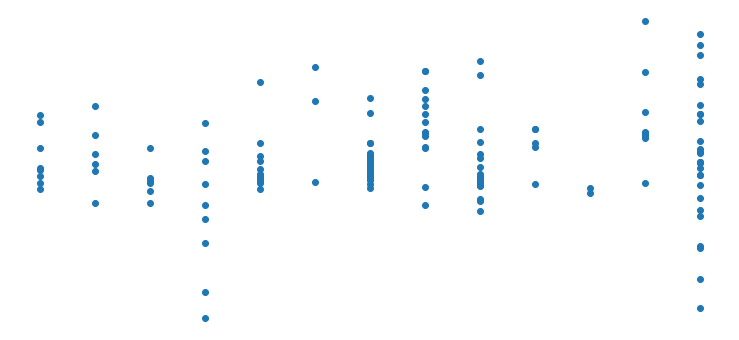

In [14]:

# Drawing project profit:
plt.figure(figsize=(13,6))
ax = plt.scatter(df.type_index, df.profit)
plt.box(False)
plt.axis('off')
plt.show()


In [20]:
df.iloc[57]

project                         YRD01
type                         Fc assay
date              2019-06-19 00:00:00
contract_value                  16705
profit                        3085.49
cost                          13619.5
profit_cost                  0.226549
type_index                          4
Name: 57, dtype: object

In [16]:
%load_ext rpy2.ipython

/Users/dsuveges/opt/anaconda3/envs/jupyter/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [39]:
%%R 

df = read.table('cleaned_profit.tsv', sep='\t', header=TRUE, comment.char = "%")

print(head(df))

  project        type       date contract_value   profit year type_index
1   OPD02   Other FFS 2018-03-22        18200.0  -6177.6 2018          8
2   ASL02   Other FFS 2018-04-19        20956.0 -10751.0 2018          8
3  DIU100   Other FFS 2018-04-20       137280.0  47086.0 2018          8
4   FAR07   Other FFS 2018-04-27        51980.5  12043.2 2018          8
5   FAR14   Other FFS 2018-07-12        20813.0   1990.3 2018          8
6  CRT100 ADC Testing 2018-07-16        15340.0   4270.5 2018          0
     cost         profit_cost
1 24377.6                 NAN
2 31707.0                 NAN
3 90194.0  0.5220524646872298
4 39937.3  0.3015526838319064
5 18822.7 0.10573934663996128
6 11069.5  0.3857897827363476


In [280]:
%%R -w 700 -h 600

get_color_gradient = function(profit_values){
    colfunc_gain = colorRampPalette(c("white","cornflowerblue"))
    colfunc_loss = colorRampPalette(c("white", "firebrick"))

    profit_min = min(profit_values, na.rm=TRUE)
    profit_max = max(profit_values, na.rm=TRUE)
    
    col_values = c()
    counter = 0
    for (profit in profit_values){
        if (is.na(profit)){
            col_values = append(col_values, NA)
        }
        else{
            if(profit >= 0){
                col_values = append(col_values, colfunc_gain(100)[ceiling(100*profit/profit_max)])
            }
            else{
                col_values = append(col_values, colfunc_loss(100)[ceiling(100*profit/profit_min)])                
            }
        }
        counter = counter + 1
    }
    return (col_values)
}
               

plot_project_type_profit = function(d, plot_label){

    # Get list of all project types:
    project_types = unique(df[,c('type','type_index')])
    project_types = project_types[order(project_types$type_index),]

    # Aggregate profit:
    agg = aggregate(profit~type, d, sum)

    # Merge aggregate with all project types:
    agg = merge(agg, project_types, by = "type", all = TRUE)

    # Setting colors
    agg['col'] = ifelse(agg$profit > 0,
        adjustcolor('cornflowerblue', alpha.f = 0.5),
        adjustcolor('firebrick', alpha.f = 0.5))

    # Get parameters:
    b = barplot(agg$profit, plot=FALSE)
    agg['xpos'] = b

    # get x/y pairs:
    points = merge(d[,c("type","profit")], agg[,c("type","xpos")], by = "type", all = TRUE)

    # Generating colors based on 
    # points['col'] = get_color_gradient(points$profit)
    points['col'] = ifelse(points$profit>0,
       adjustcolor('cornflowerblue', alpha.f = 0.5),
        adjustcolor('firebrick', alpha.f = 0.5))

    ##
    ## Setting up plotting area:
    ##
    pdf(sprintf("project_type_profit_%s.pdf", plot_label))
    par(mar=c(1,5.5,3.1,2.1), mfrow = c(2,1))

    plot(points$xpos, points$profit,, xlab='', ylab='', cex.lab=1.3,col='white',
         xlim=c(0,max(points$xpos)),axes=FALSE,
        xaxt='n',las=2, main=plot_label)
    axis(2, las=2)
    mtext('Profit/project', side=2, line=4.2, cex=1.2)

    # Adding horizontal line at 0 profit:
    abline(h=0, col='red')


    points(points$xpos, points$profit, pch=21, cex=1.4, bg=points$col)

    # Adding barchart:
    par(mar=c(7,5.5,0.5,2.1))
    barplot(agg$profit, las =2,xaxs="r", xlim=c(0,max(points$xpos)), col=agg$col)
    mtext('Sum Profit', side=2, line=4.2, cex=1.2)

    mtext(agg$type, side=1, line=1, cex=0.9, at=agg$xpos, las=2)
    dev.off()
    
}

In [284]:
%%R

# Plotting all data:
plot_project_type_profit(df, 'full')

# Generate plot for all years:
for( year in unique(df$year)){
    plot_project_type_profit(df[df$year == year,],year)
}

In [247]:
%%R



agg

              type     profit type_index       col xpos
1      ADC Testing  50333.594          0 #6495ED80  0.7
2      CLD Support   2145.156          1 #6495ED80  1.9
3  Cytokine Screen  24060.450          2 #6495ED80  3.1
4             DC:T  26836.500          3 #6495ED80  4.3
5         Fc assay  57225.950          4 #6495ED80  5.5
6      Formulation  37965.985          5 #6495ED80  6.7
7        In silico 187207.850          6 #6495ED80  7.9
8            MAPPs 180983.200          7 #6495ED80  9.1
9        Other FFS 111447.977          8 #6495ED80 10.3
10       Other FTE  83042.714          9 #6495ED80 11.5
11      Pre-Screen         NA         10      <NA> 12.7
12            TCEM 114215.100         11 #6495ED80 13.9
13     Time Course 145502.215         12 #6495ED80 15.1


In [94]:
%%R

length(b)

[1] 13
